In [146]:
import numpy as np 
import scipy.constants as PC
import matplotlib.pyplot as plt
import scipy.optimize as scopt
import sympy as sp

In [ ]:
def B_rho(p=None, E_kin=None, m_0=None):
    """
    [p] = GeV/c
    [E] = GeV
    [m_0] 0 GeV/c^2
    """
    if p:
        return 3.3356*p
    else:
        return 3.3356*np.sqrt((E_kin+m_0)**2-m_0**2)



In [ ]:
E0 = 0.511e-3 # GeV
E = 175 # GeV
E_kin = E-E0
gamma = E/E0
beta = np.sqrt(1-1/gamma**2)
p = beta*E # GeV/c
B_rho = 3.3356*p
print(E0, E_kin, E, 'GeV')
print(gamma, beta)
print(p, 'GeV/c')
print(B_rho, 'Tm')

0.000511 174.999489 175 GeV
342465.75342465757 0.9999999999957367
174.99999999925393 GeV/c
583.7299999975114 Tm


In [ ]:
rho = 10e3 # m
U0 = PC.e**2*beta**4*gamma**4/(3*PC.epsilon_0*rho)
print('Energy loss per turn per particle is {0:.2f} GeV'.format(U0/PC.e/1e9))

Energy loss per turn per particle is 8.30 GeV


In [199]:
P_particle = PC.e**2*PC.c/(6*np.pi*PC.epsilon_0)*beta**4*gamma**4/rho**2
print('Power radiated by one particle is {0:.2f} µW'.format(P_particle*1e6))

Power radiated by one particle is 6.34 µW


# 1

## a)

In [200]:
# Calculate number of particles per beam
P_beam = 50e6 # W, per beam
n_part = P_beam/P_particle

# Calculate beam current
C0 = 100e3 # m
T_rev = C0/(beta*PC.c)
I_b = n_part*PC.e/T_rev
print('Beam current is {0:.2f} mA'.format(I_b*1e3))

Beam current is 3.79 mA


In [203]:
# Estimate number of bunches
# Typical electron bunch contains around 1e10 electrons?
n_bunches = n_part/3.5e10
print('Number of bunches is {0:.0f}'.format(n_bunches))

Number of bunches is 225


## b)

In [202]:
# Calculate critical energy
E_c = 3/2*PC.hbar*PC.c/rho * gamma**3
print('Critical energy is {0:.2f} MeV'.format(E_c/PC.e/1e6))

Critical energy is 1.19 MeV


In [149]:
print('Energy loss per turn per particle is {0:.2f} GeV'.format(U0/PC.e/1e9))

Energy loss per turn per particle is 8.30 GeV


## c)

In [150]:
# Calculate cooling required
# Assume all radiation is absorbed and needs to be cooled in the arcs
L_arc_tot = 0.8*C0
P_cooling = P_beam/L_arc_tot
print('Required cooling per length is {0:.3f} kW/m'.format(P_cooling/1e3))

Required cooling per length is 0.625 kW/m


In [151]:
P_arc = P_cooling/4 # four arcs in ring
print('Required cooling per arc is {0:.2f} W'.format(P_arc))

Required cooling per arc is 156.25 W


## d)

In [152]:
U0_p = 0.06e-2*U0
gamma_p = (3*PC.epsilon_0*rho*U0_p/PC.e**2)**(1/4)
E_p = gamma_p*0.938 # GeV
print('Corresponding proton energy is {0:.2f} TeV'.format(E_p/1e3))

Corresponding proton energy is 50.28 TeV


In [153]:
beta_p = np.sqrt(1-1/gamma_p**2)
p_p = beta_p*E_p # GeV/c
B_rho = 1e9/PC.c*p_p
B = B_rho/rho
print('Required magnetic field is {0:.2f} T'.format(B))

Required magnetic field is 16.77 T


In [154]:
n_part/1e12

np.float64(7.883331203058829)

# 2

## a)

In [155]:
# Calculate transition energy
alpha_c = 7.3e-6
gamma_t = 1/np.sqrt(alpha_c)
E_t = E0*gamma_t
print('Transition energy is {0:.2f} GeV'.format(E_t))

Transition energy is 0.19 GeV


In [156]:
gamma_t

np.float64(370.11660509880267)

## b)

In [157]:
V_rf_min = U0/PC.e

In [158]:
V_rf = V_rf_min/np.sin(110/180*np.pi)
print('Required RF voltage is {0:.2f} GV'.format(V_rf/1e9))

Required RF voltage is 8.83 GV


## c)

In [ ]:
f_rf = 400e6
f_rev = 1/T_rev
h = f_rf/f_rev
eta = alpha_c-1/gamma**2
phi_s = 110/180*np.pi # rad
Qs = np.sqrt(-V_rf*h*eta*np.cos(phi_s)/(2*np.pi*beta**2*E*1e9))
print('Synchrotron tune is {0:.5f}'.format(Qs))

Synchrotron tune is 0.05172


In [160]:
# This implies a frequency of oscillation
print('Frequency of longitudinal oscillation is {0:.2f} Hz'.format(f_rev*Qs))

Frequency of longitudinal oscillation is 155.05 Hz


In [161]:
f_rev

np.float64(2997.9245799872187)

## d)

In [162]:
L_rf = V_rf/20e6 # 20 MV/m is typical gradient
print('Length of RF cavities required is {0:.2f} m'.format(L_rf))

Length of RF cavities required is 441.46 m


## e)

In [170]:
w_rf = 2*np.pi*f_rf
A_bk = 8/w_rf*np.sqrt(2*V_rf*beta**2*E*1e9/(np.pi*h*abs(eta)))*(1-np.sin(phi_s))/(1+np.sin(phi_s))
print('RF bucket acceptance is {0:.2f} eV·s'.format(A_bk))

RF bucket acceptance is 3.15 eV·s


In [171]:
h=f_rf/f_rev
E_bk = np.sqrt(2*V_rf*beta**2*E*1e9/(np.pi*h*abs(eta)))*abs(-np.cos(phi_s)+(np.pi-2*phi_s)/2*np.sin(phi_s))**(1/2)
print('RF bucket height is {0:.2f} GeV'.format(E_bk/1e9))

RF bucket height is 3.76 GeV


In [172]:
E_bk/(E*1e9)

np.float64(0.02149075790041457)

In [173]:
alpha_c*(8.3/175)*100e3/(2*np.pi)

0.005510398858250252

In [174]:
n_part/3.5e10

np.float64(225.2380343731094)

In [175]:
h

np.float64(133425.63807982966)

In [176]:
T_rev/222

np.float64(1.502540969367451e-06)

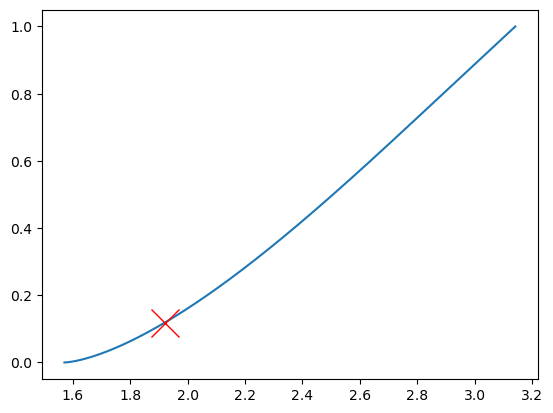

In [177]:
phi_vals = np.linspace(np.pi/2, np.pi, 1000)
plt.plot(phi_vals, abs(-np.cos(phi_vals)+(np.pi-2*phi_vals)/2*np.sin(phi_vals))**(1/2))
plt.plot(110/180*np.pi, abs(-np.cos(11/18*np.pi)+(np.pi-2*11/18*np.pi)/2*np.sin(11/18*np.pi))**(1/2), color='red', marker='x', ms=20)

# 3

## a)

In [178]:
# Calculate the damping times
jx = 1; jy = 1; jz = 2
tau_x = 2/jx*E*1e9/(U0/PC.e)*T_rev
tau_y = 2/jy*E*1e9/(U0/PC.e)*T_rev
tau_z = 2/jz*E*1e9/(U0/PC.e)*T_rev

print('The damping times are:')
print('Horizontal: {0:.2f} ms'.format(tau_x*1e3))
print('Vertical: {0:.2f} ms'.format(tau_y*1e3))
print('Longitudinal: {0:.2f} ms'.format(tau_z*1e3))
print(42*'-')
print('The revolution frequency is {0:.2f} ms'.format(T_rev*1e3))

The damping times are:
Horizontal: 14.07 ms
Vertical: 14.07 ms
Longitudinal: 7.04 ms
------------------------------------------
The revolution frequency is 0.33 ms


In [179]:
# To reach steady state, we say the emittance should be 1% of the initial emittance
# OBS: we cannot calculate equilibrium emittance, since we do not know I5 and I2. Could ask topic III people
t_steady = -tau_x/2*np.log(0.01)
print('The time to reach the steady state is {0:.2f} ms'.format(t_steady*1e3))
print('The number of turns to reach the steady state is {0:.0f}'.format(t_steady/T_rev))


The time to reach the steady state is 32.40 ms
The number of turns to reach the steady state is 97


## b)

In [ ]:
# The equilibrium energy spread is equation (I.10.42) in the synchrotron radiation book
Cq = 55/(32*np.sqrt(3))*PC.hbar/(PC.m_e*PC.c)
dE_nat = np.sqrt(Cq*gamma**2/(2*jz*(C0/(2*np.pi)))) # average rho = C0/2pi
print('The equilibrium energy spread is {0:.5f}'.format(dE_nat))

The equilibrium energy spread is 0.00084


Note that the equilibrium spread of 0.1% is much less than the energy acceptance target of 3%.  

To tune it, we would need to change the energy, the partition number (i.e. the optics), or the bending (for example by introducing negative bends)

## c)

In [196]:
# To find the bunch length, we assume we have the same ratio of bunch energy spread to separatrix
# height, as we do for the bunch length to the bucket length
# l_bunch = 2*emit_z/(np.pi*dE_nat)

ratio = dE_nat*E*1e9/E_bk
bucket_length = 1/f_rf
bunch_length = ratio*bucket_length
print('The bunch length is approximately {0:.2f} ns'.format(bunch_length*1e9))

The bunch length is approximately 0.10 ns


In [197]:
N_bunch_25_ns = C0/(PC.c*25e-9)
print('The number of bunches which fit with a 25 ns bunch spacing is {0:.0f}'.format(N_bunch_25_ns))

The number of bunches which fit with a 25 ns bunch spacing is 13343


In [209]:
bunch_spacing = C0/n_bunches/PC.c
print('The bunch spacing with our choices is {0:.2f} ns'.format(bunch_spacing*1e9))

The bunch spacing with our choices is 1480.94 ns


In [ ]:
I5_x = 2.5e-11